## Bert Attention Error Analysis: Predict without  PPI Marker

This notebook runs predictions using the ensemble without the PPI marker



In [97]:
bucket = "aegovan-data"

s3_trainfile = f"s3://{bucket}/processed_dataset/train_multiclass.json"
s3_testfile = f"s3://{bucket}/processed_dataset/test_multiclass.json"

s3_output_ensemble_models = f"s3://{bucket}/ppi_multiclass_ensemble_models/ppimulticlass-bert-f1-2021-05-10-10"
s3_input_vocab = "s3://{}/embeddings/bert/".format(bucket)



In [98]:
docker_version_tag="202110290314"
pytorch_custom_image_name=f"large-scale-ptm-ppi:gpu-{docker_version_tag}"
instance_type = "ml.p3.2xlarge" 

In [99]:
label_order = [ "acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitination"]

In [237]:
import os, sys, pandas as pd

sys.path.append("src")

pd.options.display.max_colwidth = 0


In [105]:
temp_dir = "../temp"

## PPI without markers

In [ ]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
account_id =  boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name


#role = sagemaker.get_execution_role()
role="arn:aws:iam::{}:role/service-role/AmazonSageMaker-ExecutionRole-20190118T115449".format(account_id)


In [ ]:
s3_output_predictions = "s3://{}/pubmed_asbtract/predictions_test_{}_{}/".format(bucket, "test","2021-10-01")
s3_input_data = s3_testfile
s3_data_type="S3Prefix"
usefilter=0
filter_threshold_std=1.0
instance_count = 1

s3_input_models = s3_output_ensemble_models


In [ ]:
docker_repo = "{}.dkr.ecr.{}.amazonaws.com/{}".format(account_id, region, pytorch_custom_image_name)

from sagemaker.network import NetworkConfig
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.processing import ScriptProcessor

script_processor = ScriptProcessor(image_uri=docker_repo,
                                       command=["python"],
                                       env={'mode': 'python', 'PYTHONPATH':'/opt/ml/code'},
                                       role=role,
                                       instance_type=instance_type,
                                       instance_count=instance_count,
                                       max_runtime_in_seconds= 5 * 24 * 60 * 60,
                                       volume_size_in_gb = 250,
                                       network_config=NetworkConfig(enable_network_isolation=False),
                                       base_job_name ="ppi-ensemble-test"
                                       )


sm_local_input_models = "/opt/ml/processing/input/data/models"
sm_local_input_data = "/opt/ml/processing/input/data/jsonlines"
sm_local_input_vocab = "/opt/ml/processing/input/data/vocab"


sm_local_output = "/opt/ml/processing/output"



script_processor.run(
        code='../src/inference/ppi_multiclass_batch_predict.py',

        arguments=[
            sm_local_input_data,
            sm_local_input_models,
            sm_local_output,
            "--datasetfactory", "datasets.ppi_multiclass_error_analysis_dataset_factory.PpiMulticlassErrorAnalysisDatasetFactory",
            "--ensemble", "1",
            "--tokenisor_data_dir", sm_local_input_vocab,
            "--protein_name_replacer_random_seed", "43",
            "--filter", str(usefilter),
            "--batch", "32",
            "--filterstdthreshold", str(filter_threshold_std),
            "--log-level","DEBUG"
            
        ],

        inputs=[
                ProcessingInput(
                    source=s3_input_data,
                    s3_data_type = s3_data_type,
                    destination=sm_local_input_data,
                    s3_data_distribution_type="ShardedByS3Key"),

            ProcessingInput(
                    source=s3_input_models,
                    destination=sm_local_input_models,
                    s3_data_distribution_type="FullyReplicated"),
            
            ProcessingInput(
                    source=s3_input_vocab,
                    destination=sm_local_input_vocab,
                    s3_data_distribution_type="FullyReplicated")
            ],


        outputs=[ProcessingOutput(
                source=sm_local_output, 
                destination=s3_output_predictions,
                output_name='predictions')]
    )



In [ ]:
s3_output_predictions

## Bert attention visualization

In [32]:
abstract="PROTPART1 (PROTPART1) gene plays a central role in the DNA-damage response pathway. We characterized the ATM protein expression in immortalized cells from AT and AT-variant patients, and heterozygotes and correlated it with two PROTPART1-dependent radiation responses, G1 checkpoint arrest and PROTPART2-Ser 15 phosphorylation. On Western blots, the full-length PROTPART1 protein was detected in eight of 18 AT cases, albeit at 1-32% of the normal levels, whereas a truncated PROTPART1 protein was detected in a single case, despite the prevalence among cases of truncation mutations. Of two ataxia without telangiectasia [A-(T)] cases, one expressed 20% and the other approximately 70% of the normal PROTPART1 levels. Noteworthy, among ten asymptomatic heterozygous carriers for AT, normal amounts of ATM protein were found in one and reduced by 40-50% in the remaining cases. The radiation-induced phosphorylation of PROTPART2 protein at serine 15, largely mediated by PROTPART1 kinase, was defective in AT, A(-T) and in 2/4 heterozygous carriers, while the G1 cell cycle checkpoint was disrupted in all AT and A(-T) cases, and in 3/10 AT heterozygotes. Altogether, our study shows that AT and A(-T) cases bearing truncation mutations of the ATM gene can produce modest amounts of full-length (and only rarely truncated) PROTPART1 protein. However, this limited expression of PROTPART1 protein provides no benefit regarding the ATM-dependent responses related to G1 arrest and p53-ser15 phosphorylation. Our study additionally shows that the majority of AT heterozygotes express almost halved levels of ATM protein, sufficient in most cases to normally regulate the ATM-dependent DNA damage-response pathway"

In [34]:
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

model_path =  "../temp_data/model_ppi"
do_lower_case = True
model = BertModel.from_pretrained(model_path, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=do_lower_case)
sentence= "nothing to do with this phosphorylation. radiation-induced phosphorylation of PROTPART2 protein at serine 15, largely mediated by PROTPART1 kinase & phosphorylation &  phosphorylation"

inputs = tokenizer.encode_plus(sentence,return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [35]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [36]:
head_view(attention, tokens, 1)

<IPython.core.display.Javascript object>

# BERT  output

In [50]:
raw_data =  {
    "pubmedId": "5001960",
    "participant1Id": "P01241",
    "participant1Name": "growth hormone",
    "participant2Id": "P09382",
    "participant2Name": "HPL",
    "abstract": "A radioimmunoassay for monkey placental lactogen (MPL) was developed to study the factors controlling the secretion of MPL. The sensitivity of the assay was 1 ng MPL per ml. Human and monkey growth hormone, and human placental lactogen (HPL) showed minimal cross-reactions with MPL. Maternal MPL concentrations as measured in 40 rhesus monkeys increased progressively throughout pregnancy to a mean of 5000 ng/ml at term while umbilical vein MPL was less than 50 ng/ml. After term delivery maternal MPL concentrations decreased rapidly with a t(1/2) of 20 min.After fetectomy but with retention of the placenta, MPL concentrations decreased by 25% reaching a plateau over a 6 hr period. Experimental abruption of the secondary placenta within 1 hr produced a 50% decrease in MPL concentration. After ligation of the fetal vessels supplying the secondary placental disc, MPL increased transiently and then decreased to levels significantly below those of the control period. These studies suggest MPL secretion is not directly controlled by the fetus but is sensitive to changes in placental blood flow. The pregnant rhesus monkey serves as a useful model for investigating factors which may regulate HPL secretion because of the close similarity between MPL and HPL secretion.",
    "normalised_abstract": "A radioimmunoassay for monkey P0DML3 (MPL) was developed to study the factors controlling the secretion of MPL. The sensitivity of the assay was 1 ng MPL per ml. Human and monkey P01241, and human P0DML3 (P09382) showed minimal cross-reactions with MPL. Maternal MPL concentrations as measured in 40 rhesus monkeys increased progressively throughout pregnancy to a mean of 5000 ng/ml at term while umbilical vein MPL was less than 50 ng/ml. After term delivery maternal MPL concentrations decreased rapidly with a t(1/2) of 20 min.After fetectomy but with retention of the placenta, MPL concentrations decreased by 25% reaching a plateau over a 6 hr period. Experimental abruption of the secondary placenta within 1 hr produced a 50% decrease in MPL concentration. After ligation of the fetal vessels supplying the secondary placental disc, MPL increased transiently and then decreased to levels significantly below those of the control period. These studies suggest MPL secretion is not directly controlled by the fetus but is sensitive to changes in placental blood flow. The pregnant rhesus monkey serves as a useful model for investigating factors which may regulate P09382 secretion because of the close similarity between MPL and P09382 secretion.",
    "annotations": [
      {
        "start": "30",
        "end": "48",
        "name": "placental lactogen",
        "type": "Gene",
        "normalised_id": "1443"
      },
      {
        "start": "174",
        "end": "179",
        "name": "Human",
        "type": "Species",
        "normalised_id": "9606"
      },
      {
        "start": "191",
        "end": "205",
        "name": "growth hormone",
        "type": "Gene",
        "normalised_id": "2688"
      },
      {
        "start": "211",
        "end": "216",
        "name": "human",
        "type": "Species",
        "normalised_id": "9606"
      },
      {
        "start": "217",
        "end": "235",
        "name": "placental lactogen",
        "type": "Gene",
        "normalised_id": "1443"
      },
      {
        "start": "237",
        "end": "240",
        "name": "HPL",
        "type": "Gene",
        "normalised_id": "3956"
      },
      {
        "start": "329",
        "end": "343",
        "name": "rhesus monkeys",
        "type": "Species",
        "normalised_id": "9544"
      },
      {
        "start": "1116",
        "end": "1129",
        "name": "rhesus monkey",
        "type": "Species",
        "normalised_id": "9544"
      },
      {
        "start": "1200",
        "end": "1203",
        "name": "HPL",
        "type": "Gene",
        "normalised_id": "3956"
      },
      {
        "start": "1262",
        "end": "1265",
        "name": "HPL",
        "type": "Gene",
        "normalised_id": "3956"
      }
    ],
    "gene_to_uniprot_map": {
      "1443": "P0DML3",
      "2688": "P01241",
      "3956": "P09382"
    },
    "normalised_abstract_annotations": [
      {
        "charOffset": 30,
        "len": 6,
        "text": "P0DML3"
      },
      {
        "charOffset": 179,
        "len": 6,
        "text": "P01241"
      },
      {
        "charOffset": 197,
        "len": 6,
        "text": "P0DML3"
      },
      {
        "charOffset": 205,
        "len": 6,
        "text": "P09382"
      },
      {
        "charOffset": 1171,
        "len": 6,
        "text": "P09382"
      },
      {
        "charOffset": 1236,
        "len": 6,
        "text": "P09382"
      }
    ]
  }

In [253]:
train_record = {'pubmedId': 16511572,
  'pubmedabstract': 'It has been shown that MDMX inhibits the activity of the tumor suppressor p53 by primarily cooperating with the p53 feedback regulator MDM2. Here, our study shows that this inhibition can be overcome by 14-3-3gamma and Chk1. 14-3-3gamma was identified as an MDMX-associated protein via an immuno-affinity purification-coupled mass spectrometry. Consistently, 14-3-3gamma directly interacted with MDMX in vitro, and this interaction was stimulated by MDMX phosphorylation in vitro and in cells. Interestingly, in response to UV irradiation, the wild-type, but not the kinase-dead mutant, Chk1 phosphorylated MDMX at serine 367, enhanced the 14-3-3gamma-MDMX binding and the cytoplasmic retaining of MDMX. The Chk1 specific inhibitor UCN-01 repressed all of these effects. Moreover, overexpression of 14-3-3gamma, but not its mutant K50E, which did not bind to MDMX, suppressed MDMX-enhanced p53 ubiquitination, leading to p53 stabilization and activation. Finally, ablation of 14-3-3gamma by siRNA reduced UV-induced p53 level and G1 arrest. Thus, these results demonstrate 14-3-3gamma and Chk1 as two novel regulators of MDMX in response to UV irradiation.',
  'annotations': [{'start': '23',
    'end': '27',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '74',
    'end': '77',
    'name': 'p53',
    'type': 'Gene',
    'normalised_id': '7157'},
   {'start': '112',
    'end': '115',
    'name': 'p53',
    'type': 'Gene',
    'normalised_id': '7157'},
   {'start': '135',
    'end': '139',
    'name': 'MDM2',
    'type': 'Gene',
    'normalised_id': '4193'},
   {'start': '203',
    'end': '214',
    'name': '14-3-3gamma',
    'type': 'Gene',
    'normalised_id': '7532'},
   {'start': '219',
    'end': '223',
    'name': 'Chk1',
    'type': 'Gene',
    'normalised_id': '1111'},
   {'start': '225',
    'end': '236',
    'name': '14-3-3gamma',
    'type': 'Gene',
    'normalised_id': '7532'},
   {'start': '258',
    'end': '262',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '359',
    'end': '370',
    'name': '14-3-3gamma',
    'type': 'Gene',
    'normalised_id': '7532'},
   {'start': '396',
    'end': '400',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '450',
    'end': '454',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '587',
    'end': '591',
    'name': 'Chk1',
    'type': 'Gene',
    'normalised_id': '1111'},
   {'start': '607',
    'end': '611',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '640',
    'end': '651',
    'name': '14-3-3gamma',
    'type': 'Gene',
    'normalised_id': '7532'},
   {'start': '652',
    'end': '656',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '698',
    'end': '702',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '708',
    'end': '712',
    'name': 'Chk1',
    'type': 'Gene',
    'normalised_id': '1111'},
   {'start': '799',
    'end': '810',
    'name': '14-3-3gamma',
    'type': 'Gene',
    'normalised_id': '7532'},
   {'start': '859',
    'end': '863',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '876',
    'end': '880',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'},
   {'start': '890',
    'end': '893',
    'name': 'p53',
    'type': 'Gene',
    'normalised_id': '7157'},
   {'start': '921',
    'end': '924',
    'name': 'p53',
    'type': 'Gene',
    'normalised_id': '7157'},
   {'start': '976',
    'end': '987',
    'name': '14-3-3gamma',
    'type': 'Gene',
    'normalised_id': '7532'},
   {'start': '1016',
    'end': '1019',
    'name': 'p53',
    'type': 'Gene',
    'normalised_id': '7157'},
   {'start': '1073',
    'end': '1084',
    'name': '14-3-3gamma',
    'type': 'Gene',
    'normalised_id': '7532'},
   {'start': '1089',
    'end': '1093',
    'name': 'Chk1',
    'type': 'Gene',
    'normalised_id': '1111'},
   {'start': '1121',
    'end': '1125',
    'name': 'MDMX',
    'type': 'Gene',
    'normalised_id': '4194'}],
  'num_unique_gene_normalised_id': 5,
  'num_gene_normalised_id': 27,
  'normalised_abstract': 'It has been shown that O15151 inhibits the activity of the tumor suppressor P04637 by primarily cooperating with the P04637 feedback regulator Q00987. Here, our study shows that this inhibition can be overcome by P61981 and O14757. P61981 was identified as an O15151-associated protein via an immuno-affinity purification-coupled mass spectrometry. Consistently, P61981 directly interacted with O15151 in vitro, and this interaction was stimulated by O15151 phosphorylation in vitro and in cells. Interestingly, in response to UV irradiation, the wild-type, but not the kinase-dead mutant, O14757 phosphorylated O15151 at serine 367, enhanced the P61981-O15151 binding and the cytoplasmic retaining of O15151. The O14757 specific inhibitor UCN-01 repressed all of these effects. Moreover, overexpression of P61981, but not its mutant K50E, which did not bind to O15151, suppressed O15151-enhanced P04637 ubiquitination, leading to P04637 stabilization and activation. Finally, ablation of P61981 by siRNA reduced UV-induced P04637 level and G1 arrest. Thus, these results demonstrate P61981 and O14757 as two novel regulators of O15151 in response to UV irradiation.',
  'normalised_abstract_annotations': [{'charOffset': 23,
    'len': 6,
    'text': 'O15151'},
   {'charOffset': 76, 'len': 6, 'text': 'P04637'},
   {'charOffset': 117, 'len': 6, 'text': 'P04637'},
   {'charOffset': 143, 'len': 6, 'text': 'Q00987'},
   {'charOffset': 213, 'len': 6, 'text': 'P61981'},
   {'charOffset': 224, 'len': 6, 'text': 'O14757'},
   {'charOffset': 232, 'len': 6, 'text': 'P61981'},
   {'charOffset': 260, 'len': 6, 'text': 'O15151'},
   {'charOffset': 363, 'len': 6, 'text': 'P61981'},
   {'charOffset': 395, 'len': 6, 'text': 'O15151'},
   {'charOffset': 451, 'len': 6, 'text': 'O15151'},
   {'charOffset': 590, 'len': 6, 'text': 'O14757'},
   {'charOffset': 612, 'len': 6, 'text': 'O15151'},
   {'charOffset': 647, 'len': 6, 'text': 'P61981'},
   {'charOffset': 654, 'len': 6, 'text': 'O15151'},
   {'charOffset': 702, 'len': 6, 'text': 'O15151'},
   {'charOffset': 714, 'len': 6, 'text': 'O14757'},
   {'charOffset': 807, 'len': 6, 'text': 'P61981'},
   {'charOffset': 862, 'len': 6, 'text': 'O15151'},
   {'charOffset': 881, 'len': 6, 'text': 'O15151'},
   {'charOffset': 897, 'len': 6, 'text': 'P04637'},
   {'charOffset': 931, 'len': 6, 'text': 'P04637'},
   {'charOffset': 989, 'len': 6, 'text': 'P61981'},
   {'charOffset': 1024, 'len': 6, 'text': 'P04637'},
   {'charOffset': 1084, 'len': 6, 'text': 'P61981'},
   {'charOffset': 1095, 'len': 6, 'text': 'O14757'},
   {'charOffset': 1129, 'len': 6, 'text': 'O15151'}],
  'participant1Id': 'O15151',
  'participant2Id': 'P61981',
  'gene_to_uniprot_map': {'1111': ['O14757', 'B4DT73', 'E7EPP6'],
   '4194': ['O15151',
    'Q68DC0',
    'A0A087WZ58',
    'A0A087WTR9',
    'Q59FS6',
    'A0A087WUE3'],
   '4193': ['Q00987',
    'A7UKX8',
    'G3XA89',
    'A7UKX9',
    'Q96DS0',
    'A0A0A8KB75',
    'A7UKX7'],
   '7157': ['P04637',
    'K7PPA8',
    'A0A087WT22',
    'H2EHT1',
    'Q53GA5',
    'A0A087WXZ1',
    'A0A087X1Q1'],
   '7532': ['P61981']},
  'participant1Name': 'MDMX',
  'participant2Name': '14-3-3gamma',
  'class': 'other',
  'shortest_dist': 1.0,
  'shortest_span': 'P61981 O15151'}


# train_record = {'pubmedId': 7507203,
#   'normalised_abstract': 'Src family protein tyrosine kinases (PTKs) play an essential role in antigen receptor-initiated lymphocyte activation. Their activity is largely regulated by a negative regulatory tyrosine which is a substrate for the activating action of the P08575 phosphotyrosine phosphatase (PTPase) or, conversely, the suppressing action of the cytosolic P41240 Q14289. Here we report that P08575 was phosphorylated by P41240 on two tyrosine residues, one of them identified as Tyr-1193. This residue was not phosphorylated by T-cell PTKs P06239 and P06241. Tyr-1193 was phosphorylated in intact T cells, and phosphorylation increased upon treatment with PTPase inhibitors, indicating that this tyrosine is a target for a constitutively active Q14289. Cotransfection of P08575 and P41240 into COS-1 cells caused tyrosine phosphorylation of P08575 in the intact cells. Tyrosine-phosphorylated P08575 bound P06239 through the SH2 domain of the kinase. Finally, P41240-mediated phosphorylation of P08575 caused a severalfold increase in its PTPase activity. Our results show that direct tyrosine phosphorylation of P08575 can affect its activity and association with Src family PTKs and that this phosphorylation could be mediated by P41240. If this is also true in the intact cells, it adds a new dimension to the physiological function of P41240 in T lymphocytes.',
#   'participant1Id': 'P06241',
#   'participant2Id': 'P41240',
#   'participant1Name': 'p59fyn',
#   'participant2Name': 'csk',
#   'class': 'other',
#   'normalised_abstract_annotations': [{'charOffset': 243,
#     'len': 6,
#     'text': 'P08575'},
#    {'charOffset': 343, 'len': 6, 'text': 'P41240'},
#    {'charOffset': 350, 'len': 6, 'text': 'Q14289'},
#    {'charOffset': 378, 'len': 6, 'text': 'P08575'},
#    {'charOffset': 407, 'len': 6, 'text': 'P41240'},
#    {'charOffset': 527, 'len': 6, 'text': 'P06239'},
#    {'charOffset': 538, 'len': 6, 'text': 'P06241'},
#    {'charOffset': 732, 'len': 6, 'text': 'Q14289'},
#    {'charOffset': 758, 'len': 6, 'text': 'P08575'},
#    {'charOffset': 769, 'len': 6, 'text': 'P41240'},
#    {'charOffset': 828, 'len': 6, 'text': 'P08575'},
#    {'charOffset': 880, 'len': 6, 'text': 'P08575'},
#    {'charOffset': 893, 'len': 6, 'text': 'P06239'},
#    {'charOffset': 947, 'len': 6, 'text': 'P41240'},
#    {'charOffset': 982, 'len': 6, 'text': 'P08575'},
#    {'charOffset': 1100, 'len': 6, 'text': 'P08575'},
#    {'charOffset': 1219, 'len': 6, 'text': 'P41240'},
#    {'charOffset': 1326, 'len': 6, 'text': 'P41240'}]}

In [63]:
import copy

def augment_data(raw_data) :
    p2 = raw_data["participant2Id"]
    p1 = raw_data ["participant1Id"]
    prefix = f"{p1} acetylates {p2}. "
    
    start_len = len(prefix)
    end_len = start_len+150


        
    augmented_abstract =  prefix + raw_data["normalised_abstract"][start_len:end_len]
    
    augemented_norm_annotations = []
    for a in raw_data["normalised_abstract_annotations"]:
        if (a["charOffset"] + a["len"])> len(prefix):
            augemented_norm_annotations.append(a)
            
    augemented_norm_annotations.append({
        'charOffset': prefix.find(p1),
       'len': len(p1),
       'text': p1
    })
    
    augemented_norm_annotations.append({
        'charOffset': prefix.find(p2),
       'len': len(p2),
       'text': p2
    })
    
    raw_data = copy.deepcopy(raw_data)
    
    raw_data["normalised_abstract_annotations"] = augemented_norm_annotations
    raw_data["normalised_abstract"] = augmented_abstract


    return raw_data


def print_and_return(x):
    print(x)
    return x

In [136]:
data = train_record#augment_data(raw_data)

In [65]:
raw_data 

{'pubmedId': '5001960',
 'participant1Id': 'P01241',
 'participant1Name': 'growth hormone',
 'participant2Id': 'P09382',
 'participant2Name': 'HPL',
 'abstract': 'A radioimmunoassay for monkey placental lactogen (MPL) was developed to study the factors controlling the secretion of MPL. The sensitivity of the assay was 1 ng MPL per ml. Human and monkey growth hormone, and human placental lactogen (HPL) showed minimal cross-reactions with MPL. Maternal MPL concentrations as measured in 40 rhesus monkeys increased progressively throughout pregnancy to a mean of 5000 ng/ml at term while umbilical vein MPL was less than 50 ng/ml. After term delivery maternal MPL concentrations decreased rapidly with a t(1/2) of 20 min.After fetectomy but with retention of the placenta, MPL concentrations decreased by 25% reaching a plateau over a 6 hr period. Experimental abruption of the secondary placenta within 1 hr produced a 50% decrease in MPL concentration. After ligation of the fetal vessels supplyi

In [66]:
raw_data["abstract"]

'A radioimmunoassay for monkey placental lactogen (MPL) was developed to study the factors controlling the secretion of MPL. The sensitivity of the assay was 1 ng MPL per ml. Human and monkey growth hormone, and human placental lactogen (HPL) showed minimal cross-reactions with MPL. Maternal MPL concentrations as measured in 40 rhesus monkeys increased progressively throughout pregnancy to a mean of 5000 ng/ml at term while umbilical vein MPL was less than 50 ng/ml. After term delivery maternal MPL concentrations decreased rapidly with a t(1/2) of 20 min.After fetectomy but with retention of the placenta, MPL concentrations decreased by 25% reaching a plateau over a 6 hr period. Experimental abruption of the secondary placenta within 1 hr produced a 50% decrease in MPL concentration. After ligation of the fetal vessels supplying the secondary placental disc, MPL increased transiently and then decreased to levels significantly below those of the control period. These studies suggest MPL

In [67]:
raw_data["normalised_abstract"]

'A radioimmunoassay for monkey P0DML3 (MPL) was developed to study the factors controlling the secretion of MPL. The sensitivity of the assay was 1 ng MPL per ml. Human and monkey P01241, and human P0DML3 (P09382) showed minimal cross-reactions with MPL. Maternal MPL concentrations as measured in 40 rhesus monkeys increased progressively throughout pregnancy to a mean of 5000 ng/ml at term while umbilical vein MPL was less than 50 ng/ml. After term delivery maternal MPL concentrations decreased rapidly with a t(1/2) of 20 min.After fetectomy but with retention of the placenta, MPL concentrations decreased by 25% reaching a plateau over a 6 hr period. Experimental abruption of the secondary placenta within 1 hr produced a 50% decrease in MPL concentration. After ligation of the fetal vessels supplying the secondary placental disc, MPL increased transiently and then decreased to levels significantly below those of the control period. These studies suggest MPL secretion is not directly co

In [68]:
data["normalised_abstract"]

'P01241 acetylates P09382. key P0DML3 (MPL) was developed to study the factors controlling the secretion of MPL. The sensitivity of the assay was 1 ng MPL per ml. Human and monkey P01241, and human P0DML3 (P09382) showed minimal cross-reactions with MPL. Maternal MPL concentrations as measured in 40 rhesus monkeys increased progressively throughout pregnancy to a mean of 5000 ng/ml at term while umbilical vein MPL was less than 50 ng/ml. After term delivery maternal MPL concentrations decreased rapidly with a t(1/2) of 20 min.After fetectomy but with retention of the placenta, MPL concentrations decreased by 25% reaching a plateau over a 6 hr period. Experimental abruption of the secondary placenta within 1 hr produced a 50% decrease in MPL concentration. After ligation of the fetal vessels supplying the secondary placental disc, MPL increased transiently and then decreased to levels significantly below those of the control period. These studies suggest MPL secretion is not directly co

In [186]:
fake_data = {
    "abstract": "Src family protein tyrosine kinases (PTKs) play an essential role in antigen receptor-initiated lymphocyte activation. Their activity is largely regulated by a negative regulatory tyrosine which is a substrate for the activating action of the PROTPART1 phosphotyrosine phosphatase (PTPase) or, conversely, the suppressing action of the cytosolic PROTPART0 PRTIG0. This residue was not phosphorylated by T-cell PTKs PRTIG1 and PRTIG2. Tyr-1193 was phosphorylated in intact T cells, and phosphorylation increased upon treatment with PTPase inhibitors, indicating that this tyrosine is a target for a constitutively active PRTIG0. Cotransfection of PROTPART1 into COS-1 cells caused tyrosine phosphorylation.  Tyrosine-phosphorylated PROTPART1 bound PRTIG1 through the SH2 domain of the kinase .  Our results show that direct tyrosine phosphorylation of PROTPART1  can affect its activity and association with Src family PTKs and that this phosphorylation could be mediated. If this is also true in the intact cells, it adds a new dimension to the physiological function of PROTPART0 in T lymphocytes"
}

In [254]:
data = train_record

In [255]:
import sys
sys.path.append("./src")
import torch
from bertviz import head_view, model_view
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from datasets.transformer_bert_tokeniser import TransformerBertTokeniser

from datasets.transformer_name_normaliser import TransformerNameNormaliser
from datasets.transformer_ppi_participant_augmentor import TransformerPPIParticipantAugmentor
from datasets.transformer_chain import TransformerChain

def get_data_transformer():
    transformer_list = [
                TransformerPPIParticipantAugmentor(participant1_key="participant1Id"
                                                   , participant2_key="participant2Id"
                                                   , annotations_dict_key="normalised_abstract_annotations"
                                                   , result_key_participant="participantEntities"
                                                   , result_key_other="otherEntities"
                                                   ),
                TransformerNameNormaliser(text_key="normalised_abstract",
                                          participants_entities_dict_key="participantEntities",
                                          other_entities_dict_key="otherEntities",
                                          random_seed=42)
            ]
    tokenizer = TransformerBertTokeniser(512, BertTokenizer.from_pretrained(model_path, do_lower_case=do_lower_case))


    transformer_list = transformer_list + [ print_and_return , tokenizer]
    #transformer_list = [lambda x: x["abstract"],print_and_return, tokenizer]
    transformer_chain = TransformerChain(transformer_list)
    
    return transformer_chain
    


soft_max_func = torch.nn.Softmax(dim=-1)
model_path =  "../temp_data/model_ppi"
do_lower_case = True
model = BertForSequenceClassification.from_pretrained(model_path)



inputs =  get_data_transformer()(data).unsqueeze(dim=0)

model.eval()
with torch.no_grad():
    output = model(inputs)[0]
soft_max_func(output)

It has been shown that PROTPART1 inhibits the activity of the tumor suppressor PRTIG2 by primarily cooperating with the PRTIG2 feedback regulator PRTIG0. Here, our study shows that this inhibition can be overcome by PROTPART0 and PRTIG1. PROTPART0 was identified as an PROTPART1-associated protein via an immuno-affinity purification-coupled mass spectrometry. Consistently, PROTPART0 directly interacted with PROTPART1 in vitro, and this interaction was stimulated by PROTPART1 phosphorylation in vitro and in cells. Interestingly, in response to UV irradiation, the wild-type, but not the kinase-dead mutant, PRTIG1 phosphorylated PROTPART1 at serine 367, enhanced the PROTPART0-PROTPART1 binding and the cytoplasmic retaining of PROTPART1. The PRTIG1 specific inhibitor UCN-01 repressed all of these effects. Moreover, overexpression of PROTPART0, but not its mutant K50E, which did not bind to PROTPART1, suppressed PROTPART1-enhanced PRTIG2 ubiquitination, leading to PRTIG2 stabilization and ac

tensor([[9.9643e-01, 1.6572e-03, 8.0995e-04, 2.1787e-04, 3.2006e-04, 2.9090e-04,
         2.7075e-04]])

In [9]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Analyse Train

In [244]:
import re

def shortest_distance(text, p1, p2):
    words = re.split('\W+',text)

    start_i = None
    end_i = None
    min_distance=None
    min_distance_start = None
    min_distance_word = None
    
    for i, w in enumerate(words):
        
        if w not in [p1, p2]: continue
        
        # Treat this reset start pointer
        # Case 
        #     when new 
        #     when w = start_i
        if start_i is None or w == words[start_i]:
            start_i = i
            start_w = w
            
        else:
            end_i =i
            
            distance = end_i - start_i 
            if min_distance is None or min_distance > distance:
                min_distance = distance
                min_distance_start = start_i, end_i
            
                min_distance_word = " ".join( words[start_i : end_i+1])
            # Reset start
            start_i = end_i
    return min_distance, min_distance_word
            
        
            
shortest_distance("the brown quick frog the quick", "the" , "quick")
        
        
            

(1, 'the quick')

In [109]:
from utils.s3_utils import download_file
import pandas as pd

In [106]:
local_train_file = download_file(s3_trainfile, temp_dir)

In [110]:
train_df = pd.read_json(local_train_file)

In [117]:
train_df.head()

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,participant1Name,participant2Name,class
0,17197020,"In HEK293 cells, transfected with the Ca2+ cha...","[{'start': '3', 'end': '9', 'name': 'HEK293', ...",4,10,"In HEK293 cells, transfected with the Ca2+ cha...","[{'charOffset': 59, 'len': 6, 'text': 'Q9H1D0'...",Q9H1D0,P18031,"{'55503': ['Q9H1D0'], '5464': ['Q15181', 'V9HW...",TRPV6,PTP1B,dephosphorylation
1,17053781,"Receptor interacting protein 140 (RIP140), a l...","[{'start': '0', 'end': '32', 'name': 'Receptor...",3,12,"P48552 (P48552), a ligand-dependent corepresso...","[{'charOffset': 0, 'len': 6, 'text': 'P48552'}...",Q99873,P48552,"{'8204': ['P48552', 'A8K171'], '7514': ['O1498...",protein arginine methyltransferase 1,Receptor interacting protein 140,methylation
2,17079228,TAK1 (transforming growth factor beta-activate...,"[{'start': '0', 'end': '4', 'name': 'TAK1', 't...",5,24,O43318 (O43318) is a serine/threonine kinase t...,"[{'charOffset': 0, 'len': 6, 'text': 'O43318'}...",O00743,O43318,"{'6885': ['O43318'], '5524': ['Q15257', 'B4DZF...",protein phosphatase 6,TAK1,dephosphorylation
3,17318191,Self-renewal of Bcr-Abl(+) chronic myeloid leu...,"[{'start': '16', 'end': '23', 'name': 'Bcr-Abl...",6,27,Self-renewal of P00519(+) chronic myeloid leuk...,"[{'charOffset': 16, 'len': 6, 'text': 'P00519'...",P00519,P35222,"{'1499': ['P35222', 'B4DGU4', 'A0A024R2Q3'], '...",Bcr-Abl,beta-catenin,phosphorylation
4,17108971,Specific sites of lysine methylation on histon...,"[{'start': '136', 'end': '139', 'name': 'p53',...",3,15,Specific sites of lysine methylation on histon...,"[{'charOffset': 136, 'len': 6, 'text': 'P04637...",Q8WTS6,P04637,"{'80854': ['Q8WTS6', 'B5MCZ8', 'D6RJA0'], '715...",Set9,p53,methylation


<AxesSubplot:ylabel='Frequency'>

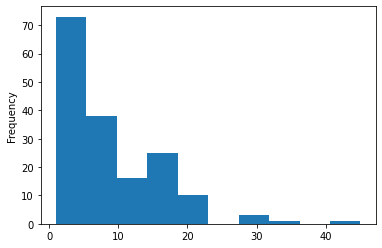

In [116]:
train_df.groupby("pubmedId").size().plot.hist()

<AxesSubplot:ylabel='Frequency'>

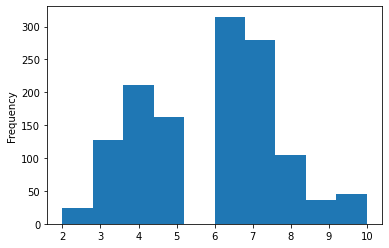

In [119]:

train_df.num_unique_gene_normalised_id.plot.hist()

In [131]:
train_df.query("pubmedId == '7507203'")[["pubmedId", "normalised_abstract", "participant1Id", "participant2Id", "participant1Name", "participant2Name", "class", "normalised_abstract_annotations"]].to_dict(orient='records')

[{'pubmedId': 7507203,
  'normalised_abstract': 'Src family protein tyrosine kinases (PTKs) play an essential role in antigen receptor-initiated lymphocyte activation. Their activity is largely regulated by a negative regulatory tyrosine which is a substrate for the activating action of the P08575 phosphotyrosine phosphatase (PTPase) or, conversely, the suppressing action of the cytosolic P41240 Q14289. Here we report that P08575 was phosphorylated by P41240 on two tyrosine residues, one of them identified as Tyr-1193. This residue was not phosphorylated by T-cell PTKs P06239 and P06241. Tyr-1193 was phosphorylated in intact T cells, and phosphorylation increased upon treatment with PTPase inhibitors, indicating that this tyrosine is a target for a constitutively active Q14289. Cotransfection of P08575 and P41240 into COS-1 cells caused tyrosine phosphorylation of P08575 in the intact cells. Tyrosine-phosphorylated P08575 bound P06239 through the SH2 domain of the kinase. Finally, P412

In [245]:
train_df["shortest_dist"] = train_df.apply(lambda r: shortest_distance(r["normalised_abstract"], r["participant1Id"], r["participant2Id"])[0],
                                           axis=1)

train_df["shortest_span"] = train_df.apply(lambda r: shortest_distance(r["normalised_abstract"], r["participant1Id"], r["participant2Id"])[1],
                                           axis=1)

In [246]:
train_df.groupby("class")["shortest_dist"].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
acetylation,5.0,3.400000,1.516575,2.0,3.00,3.0,3.00,6.0
dephosphorylation,28.0,7.892857,18.517938,1.0,2.00,3.5,6.25,101.0
deubiquitination,2.0,2.500000,0.707107,2.0,2.25,2.5,2.75,3.0
methylation,10.0,2.800000,1.229273,2.0,2.00,2.5,3.00,6.0
other,1103.0,19.761559,27.606325,1.0,3.00,9.0,22.00,178.0
phosphorylation,138.0,5.463768,8.919068,1.0,2.00,2.0,5.75,71.0
ubiquitination,5.0,11.400000,15.646086,2.0,2.00,6.0,8.00,39.0


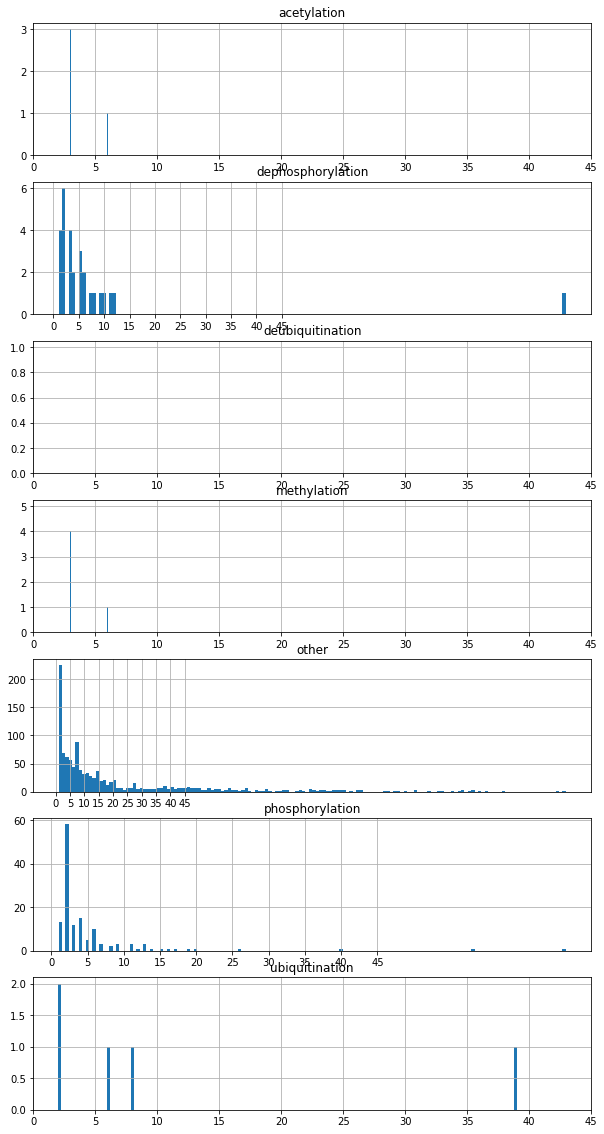

In [275]:
import matplotlib.pyplot as plt
_, ax=plt.subplots(train_df["class"].nunique(), figsize=(10,20))

for i, (a, g ) in enumerate(train_df.groupby("class")):
    g["shortest_dist"].hist(ax=ax[i], bins=150)
    ax[i].set_title(a)
    ax[i].set_xticks(list(range(0,50, 5)))


In [256]:
train_df.query("shortest_dist <=3").sample(n=5)#.to_dict(orient="records")

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,participant1Name,participant2Name,class,shortest_dist,shortest_span
79,15103385,"COP1 (constitutively photomorphogenic 1) is a RING-finger-containing protein that functions to repress plant photomorphogenesis, the light-mediated programme of plant development. Mutants of COP1 are constitutively photomorphogenic, and this has been attributed to their inability to negatively regulate the proteins LAF1 (ref. 1) and HY5 (ref. 2). The role of COP1 in mammalian cells is less well characterized. Here we identify the tumour-suppressor protein p53 as a COP1-interacting protein. COP1 increases p53 turnover by targeting it for degradation by the proteasome in a ubiquitin-dependent fashion, independently of MDM2 or Pirh2, which are known to interact with and negatively regulate p53. Moreover, COP1 serves as an E3 ubiquitin ligase for p53 in vitro and in vivo, and inhibits p53-dependent transcription and apoptosis. Depletion of COP1 by short interfering RNA (siRNA) stabilizes p53 and arrests cells in the G1 phase of the cell cycle. Furthermore, we identify COP1 as a p53-inducible gene, and show that the depletion of COP1 and MDM2 by siRNA cooperatively sensitizes U2-OS cells to ionizing-radiation-induced cell death. Overall, these results indicate that COP1 is a critical negative regulator of p53 and represents a new pathway for maintaining p53 at low levels in unstressed cells.","[{'start': '0', 'end': '4', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '6', 'end': '39', 'name': 'constitutively photomorphogenic 1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '191', 'end': '195', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '361', 'end': '365', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '369', 'end': '378', 'name': 'mammalian', 'type': 'Species', 'normalised_id': '9606'}, {'start': '460', 'end': '463', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '469', 'end': '473', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '495', 'end': '499', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '510', 'end': '513', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '624', 'end': '628', 'name': 'MDM2', 'type': 'Gene', 'normalised_id': '4193'}, {'start': '632', 'end': '637', 'name': 'Pirh2', 'type': 'Gene', 'normalised_id': '25898'}, {'start': '696', 'end': '699', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '711', 'end': '715', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '753', 'end': '756', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '792', 'end': '795', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '848', 'end': '852', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '897', 'end': '900', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '979', 'end': '983', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '989', 'end': '992', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '1040', 'end': '1044', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '1049', 'end': '1053', 'name': 'MDM2', 'type': 'Gene', 'normalised_id': '4193'}, {'start': '1088', 'end': '1093', 'name': 'U2-OS', 'type': 'Species', 'normalised_id': '9606'}, {'start': '1179', 'end': '1183', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '1220', 'end': '1223', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}, {'start': '1269', 'end': '1272', 'name': 'p53', 'type': 'Gene', 'normalised_id': '7157'}]",4,23,"Q8NHY2 (Q8NHY2) is a RING-finger-containing protein that functions to repress plant photomorphogenesis, the light-mediated programme o